In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from tqdm import tqdm
from scipy.optimize import minimize


from oceanoi import cov, oi, variogram

In [2]:
plt.rcParams['pcolor.shading'] = 'auto'

((38, 36, 30), (38,), (36,), (30,))

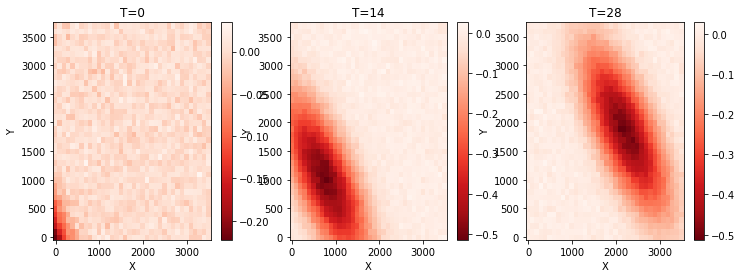

In [3]:
# Create a dataset for a propagating (soliton-like) signal
def rotate_xy_deg(xin, yin, thetadeg):
    theta = np.pi*thetadeg/180
    cost = np.cos(theta)
    sint = np.sin(theta)
    return xin*cost - yin*sint, xin*sint + yin*cost

#####
# parameters
a0=0.5
lx = 1600.
ly = 600.
thetadeg = 60.
c = 1.0
x0 = -500.
y0 = -500.
noise = 0.01

tmax = 3600.

dx = 100
dt = 120.

######
thetarad = np.pi*thetadeg/180
x = np.arange(0, tmax*c, dx)
y = np.arange(0, tmax*c+2*dx, dx)
t = np.arange(0, tmax, dt)

X,Y,T = np.meshgrid(x,y,t)
Xr, Yr = rotate_xy_deg(X, Y, thetadeg)
cx = c*np.cos(thetarad)
cy = c*np.sin(thetarad)

u = -a0* \
    np.exp( -( (Xr-x0)**2/lx**2 + 
          (Yr-c*T-y0)**2/ly**2 
        ) )\
    + noise*np.random.normal(size=X.shape)
    
# u = -a0* \
#     np.exp( -( (X-cx*T-x0)**2/lx**2 + 
#           (Y-cy*T-y0)**2/ly**2 +
#           (X-cx*T-x0)*(Y-cy*T-y0)/(lx*ly*np.cos(thetarad))    
#         ) )\
#     + 0.01*np.random.normal(size=X.shape)
    



plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')
u.shape, y.shape, x.shape, t.shape


In [47]:
%%time
# Take a random sample of the data for a 2D 
ny,nx,nt = u.shape
nsamples = 1000
rr = np.random.randint(ny,size=nsamples)
cc = np.random.randint(nx,size=nsamples)
ii = np.random.randint(nt,size=nsamples)

xx = X[rr,cc,ii]
yy = Y[rr,cc,ii]
tt = T[rr,cc,ii]

Z = u[rr,cc,ii]

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx,yy,zs=tt,s=np.abs(Z)*100,c=Z, cmap='Reds',alpha=0.2)


CPU times: user 24 ms, sys: 23.9 ms, total: 48 ms
Wall time: 43.3 ms


In [60]:
# Minimize the log marginal likelihood
def minfunc( params, x, y, t, Z, covfunc):
    #print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = oi.OptimalInterp3D(x, x, y, y, t, t, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)

    print(nll, covparams)
    return nll

scale = 1e-3
covfunc = cov.rotated_expquad_cov_3d
covparams_ic = ( 0.01, 0.2, 1., 0.5,0.5, 0.0,0.1,0.2)
method = 'L-BFGS-B'
# method = 'powell'

# bounds =( (0.01,0.02), (0.05,2*dx), (0.2, 20.)) 
pi2 = np.pi
bounds = ((0.01,0.05), (0.01,1), (0.1,1), (0.1,1), (0.1,1), (0,pi2), (0,pi2), (0,pi2))
# bounds = None
options = {'eps':1e-4}

# def optlog(x):
#     print(x)

soln = minimize(minfunc, covparams_ic,
         args=(xx*scale, yy*scale, tt*scale,  Z[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x']

44066.48200860086 [0.2 1.  0.5 0.5 0.  0.1 0.2]
43154.252325464186 [0.2 1.  0.5 0.5 0.  0.1 0.2]
44065.91279289234 [0.2001 1.     0.5    0.5    0.     0.1    0.2   ]
44066.383382388216 [0.2    0.9999 0.5    0.5    0.     0.1    0.2   ]
44067.20810066034 [0.2    1.     0.5001 0.5    0.     0.1    0.2   ]
44067.40456677082 [0.2    1.     0.5    0.5001 0.     0.1    0.2   ]
44066.2140214219 [2.e-01 1.e+00 5.e-01 5.e-01 1.e-04 1.e-01 2.e-01]
44066.568853523095 [0.2    1.     0.5    0.5    0.     0.1001 0.2   ]
44066.50876415858 [0.2    1.     0.5    0.5    0.     0.1    0.2001]
621.7250343319333 [1.         0.1        0.1        0.1        3.14159265 0.
 0.        ]
623.7140118348306 [1.         0.1        0.1        0.1        3.14159265 0.
 0.        ]
621.6577339355011 [0.9999     0.1        0.1        0.1        3.14159265 0.
 0.        ]
621.6536071720141 [1.         0.1001     0.1        0.1        3.14159265 0.
 0.        ]
621.6536071720125 [1.         0.1        0.1001     0.1    

array([5.00000000e-02, 1.10806149e-01, 1.00000000e-01, 8.55712922e-01,
       1.00000000e-01, 2.35568894e+00, 1.83841712e-03, 0.00000000e+00])

In [61]:
soln

      fun: -425.3769110572239
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.14221383e+04,  6.98487611e-03,  3.21878330e+02,  1.98269845e-06,
        7.48540867e+02, -4.62289108e-03,  6.69448764e-02,  6.68859457e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 756
      nit: 38
     njev: 84
   status: 0
  success: True
        x: array([5.00000000e-02, 1.10806149e-01, 1.00000000e-01, 8.55712922e-01,
       1.00000000e-01, 2.35568894e+00, 1.83841712e-03, 0.00000000e+00])

In [64]:
# %%time
scale = 1e-3
# Optimal interpolation using "time-series" data i.e., from pseudo-moorings
ny,nx,nt = u.shape

# Example set of stations to extract time-series data from
# cc = [10,20,30, 12]
# rr = [5,15,22, 22]
cc = [10,]
rr = [22]

xd = X[rr,cc,:].ravel()
yd = Y[rr,cc,:].ravel()
td = T[rr,cc,:].ravel()
zd = u[rr,cc,:].ravel()

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xd*scale, yd*scale, td*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])
    U_oi[...,ii] = OI(zd[:,None]).reshape((ny,nx))

# plt.figure()

0
14
28


Text(0.5, 1.0, 'T=28')

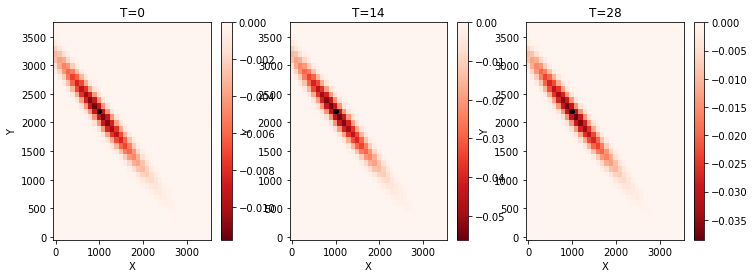

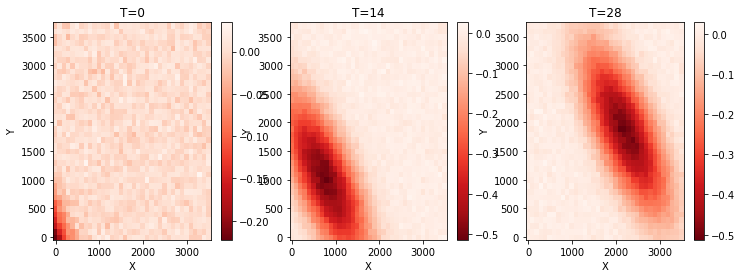

In [65]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')
